# Pressure signal of Weather Dataset
This notebook demonstrates the process of preparing a pressure signal from the Weather Dataset and splitting it into the necessary signals for subsequent analysis.

In [1]:
#import libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.api import OLS
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

## Prepare raw data
The observation period is limited to 1961-2020. Unnecessary columns have been deleted.

In [2]:
#read the raw data from a .txt file with a specified separator (';')
df = pd.read_csv('Weather_raw/produkt_p0_stunde_19490101_20221231_00282.txt', sep=';')

#display the first 5 rows of the dataframe
df.head()

STATIONS_ID  MESS_DATUM  QN_8       P     P0  eor
0          282  1949010100     1  1006.3 -999.0  eor
1          282  1949010103     1  1004.7 -999.0  eor
2          282  1949010106     1  1001.6 -999.0  eor
3          282  1949010109     1  1000.3 -999.0  eor
4          282  1949010112     1   996.7 -999.0  eor

In [3]:
#delete the unnecessary columns from the DataFrame
column_drop = ['STATIONS_ID','QN_8','P0','eor']
df = df.drop(column_drop, axis=1)

#convert the 'MESS_DATUM' column to datetime format using the specified format
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H')

#extract year, month, and day from the 'MESS_DATUM' column and create new columns for each
df['Year'] = df['MESS_DATUM'].dt.year
df['Month'] = df['MESS_DATUM'].dt.month
df['Day'] = df['MESS_DATUM'].dt.day
df.head()

MESS_DATUM       P  Year  Month  Day
0 1949-01-01 00:00:00  1006.3  1949      1    1
1 1949-01-01 03:00:00  1004.7  1949      1    1
2 1949-01-01 06:00:00  1001.6  1949      1    1
3 1949-01-01 09:00:00  1000.3  1949      1    1
4 1949-01-01 12:00:00   996.7  1949      1    1

In [4]:
#define the condition for filtering based on the 'Year' column
condition = (df['Year'] >= 1961) & (df['Year'] <= 2020)

#apply the condition to filter the DataFrame and save results in a new filtered_df DataFrame
filtered_df = df.loc[condition]
filtered_df.head()

MESS_DATUM       P  Year  Month  Day
32467 1961-01-01 03:00:00  1015.6  1961      1    1
32468 1961-01-01 06:00:00  1015.6  1961      1    1
32469 1961-01-01 09:00:00  1016.0  1961      1    1
32470 1961-01-01 12:00:00  1015.6  1961      1    1
32471 1961-01-01 15:00:00  1015.8  1961      1    1

## Impute missing values:
First, check the amount and percentage of missing values. Then, use the interpolate method to impute the missing values.

In [5]:
#find missing values
missing_values_df = filtered_df[filtered_df['P'] == -999]

#print information about missing value
print(f'Anout of data points: {len(filtered_df)}')
print(f'Anounts of missing values: {len(missing_values_df)}')
print(f'Percent missing values: {len(missing_values_df) / len(filtered_df) *100}')

Anout of data points: 344768
Anounts of missing values: 8879
Percent missing values: 2.575355021347689


In [6]:
#impute missing values using interpolate method
filtered_df['P'] = filtered_df['P'].replace(-999 ,None)
filtered_df['P'].interpolate(method='linear', inplace=True)
filtered_df.head()

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_5615/3857589198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['P'] = filtered_df['P'].replace(-999 ,None)
/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_5615/3857589198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['P'].interpolate(method='linear', inplace=True)


MESS_DATUM       P  Year  Month  Day
32467 1961-01-01 03:00:00  1015.6  1961      1    1
32468 1961-01-01 06:00:00  1015.6  1961      1    1
32469 1961-01-01 09:00:00  1016.0  1961      1    1
32470 1961-01-01 12:00:00  1015.6  1961      1    1
32471 1961-01-01 15:00:00  1015.8  1961      1    1

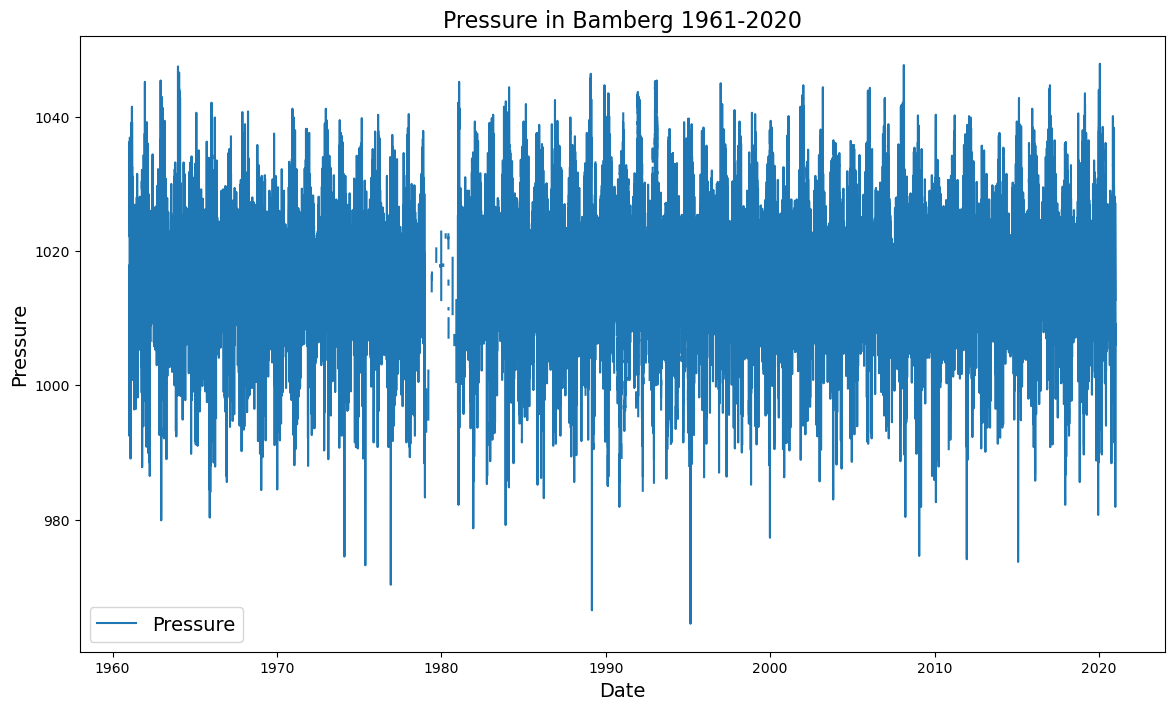

In [7]:
#set the index of 'filtered_df' to the 'MESS_DATUM' column
filtered_df.set_index('MESS_DATUM', inplace=True)

#convert the index to a datetime format
filtered_df.index = pd.to_datetime(filtered_df.index)

#plot the whole raw dataset 
plt.figure(figsize=(14, 8))
plt.plot(filtered_df.index, filtered_df['P'])

plt.legend(['Pressure'], fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Pressure',fontsize = 14)
plt.title('Pressure in Bamberg 1961-2020', fontsize = 16)
plt.show()

In [8]:
#save the information as a .csv file for the following analysis
filtered_df.to_csv('Pressure/pressure_Bamberg.csv',index=True)

## Create a daily average signals
Create a daily average signal, then split it into decades, training, and test datasets for the subsequent analysis.

In [ ]:
#optional
#filtered_df = pd.read_csv('Pressure/pressure_Bamberg.csv', index_col=0, parse_dates=True)
#filtered_df.head()

Aggregate daily mean pressure.

In [9]:
#calculate the daily average pressure by grouping data by year, month, and day, and then taking the mean of 'P'
daily_avg = filtered_df.groupby(['Year', 'Month', 'Day'])['P'].mean().reset_index()

#round the 'P' values to two decimal places
daily_avg['P'] = daily_avg['P'].round(2)

#create a 'MESS_DATUM' column by combining the 'Year', 'Month', and 'Day' columns and formatting it as '%Y-%m-%d'
daily_avg['MESS_DATUM'] = pd.to_datetime(daily_avg[['Year', 'Month', 'Day']]).dt.strftime('%Y-%m-%d')

#delete the unnecessary columns from the DataFrame and rearrange the rest
column_drop = ['Year', 'Month', 'Day']
daily_avg = daily_avg.drop(column_drop, axis=1)
daily_avg = daily_avg[['MESS_DATUM', 'P']]
daily_avg.head()

MESS_DATUM        P
0  1961-01-01  1015.79
1  1961-01-02  1010.07
2  1961-01-03   994.96
3  1961-01-04   997.86
4  1961-01-05  1010.89

In [10]:
#print a summary of DataFrame
daily_avg.describe()

P
count  21858.000000
mean    1016.959845
std        8.633832
min      969.780000
25%     1011.722500
50%     1016.950000
75%     1022.380000
max     1046.800000

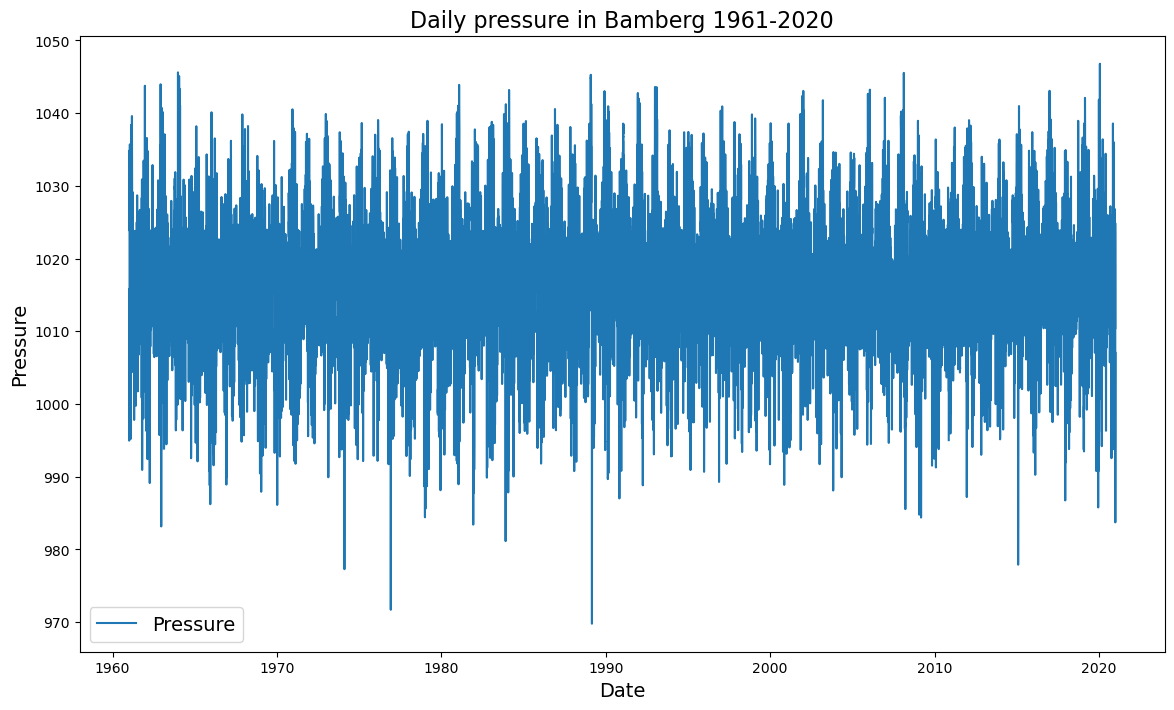

In [11]:
#set the index of 'daily_avg' to the 'MESS_DATUM' column
daily_avg.set_index('MESS_DATUM', inplace=True)

#convert the index to a datetime format
daily_avg.index = pd.to_datetime(daily_avg.index)

#plot the whole dataset
plt.figure(figsize=(14, 8))
plt.plot(daily_avg.index, daily_avg['P']) 
plt.legend(['Pressure'], fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Pressure',fontsize = 14)
plt.title('Daily pressure in Bamberg 1961-2020', fontsize = 16)

plt.show()

In [12]:
#save the information as a .csv file for the following analysis
daily_avg.to_csv('Pressure/daily_pressure_Bamberg.csv',index=True)

Decomposition

Create a decomposition of the daily average tpressure signal to display its components: trend, seasonality, and residuals.

In [ ]:
#optional
#daily_avg = pd.read_csv('Pressure/daily_pressure_Bamberg.csv', index_col=0, parse_dates=True)
#daily_avg.head()

In [13]:
#impute missing values using interpolate method
missing_values = daily_avg['P'].isna() 
#Count missing values per column
missing_count = missing_values.sum()
if missing_count >=1: #if we have
    daily_avg['P'].interpolate(inplace=True)


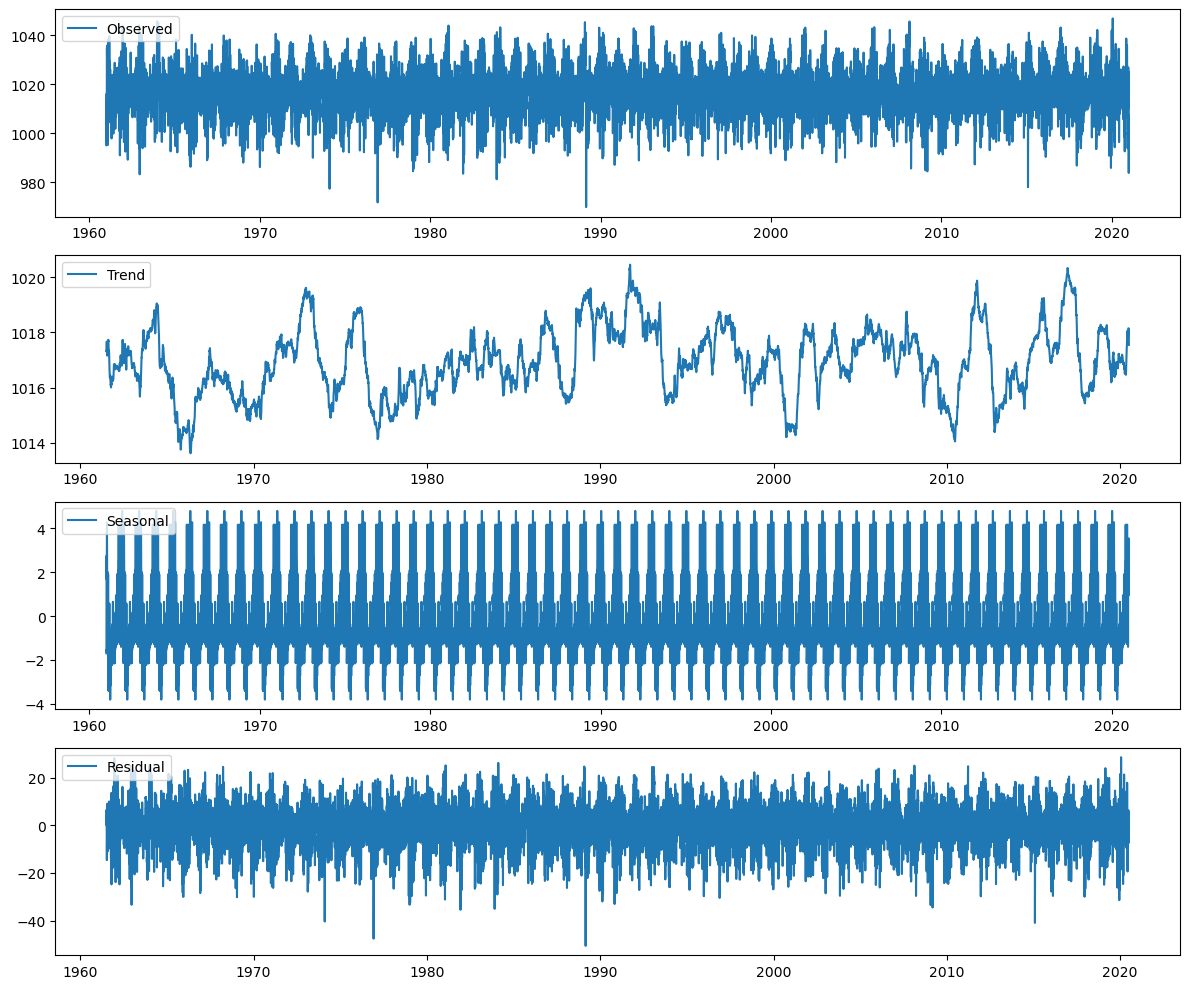

In [14]:
#perform seasonal decomposition 
result = seasonal_decompose(daily_avg['P'], model='additive', period=365)  #additive model
#result = seasonal_decompose(daily_avg['P'], model='multiplicative', period=365)  #multiplicative model

#plot the decomposed components
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Split into decade.

Split the 'daily_pressure_Bamberg.csv' signal into decade periods.

In [16]:
def filter_and_save_dataframe(dataframe, start_year, end_year):
    """
    Filters a DataFrame based on the 'YEAR' column within the specified year range and saves the result to a CSV file.

    :param dataframe: The input DataFrame.
    :param start_year: The starting year.
    :param end_year: The ending year (exclusive).
    :param output_csv_filename: The name of the CSV file to save the result.
    """
    output_csv_filename = f'Pressure/daily_pressure_Bamberg_{start_year}-{end_year-1}.csv'
    condition = (dataframe['Year'] >= start_year) & (dataframe['Year'] < end_year)
    filtered_df = dataframe.loc[condition]
    filtered_df = filtered_df.drop(['Year'],axis=1)
    filtered_df.to_csv(output_csv_filename, index=False)

In [15]:
#read the daily pressure data
df = pd.read_csv('Pressure/daily_pressure_Bamberg.csv')

#convert the 'MESS_DATUM' column to datetime format
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'])

#extract the year information from the 'MESS_DATUM' column
df['Year'] = df['MESS_DATUM'].dt.year
df.head()

MESS_DATUM        P  Year
0 1961-01-01  1015.79  1961
1 1961-01-02  1010.07  1961
2 1961-01-03   994.96  1961
3 1961-01-04   997.86  1961
4 1961-01-05  1010.89  1961

In [17]:
#split into decades
for i in range(1961, 2020, 10):
    start_year, end_year = i, i+10
    print(start_year, end_year)
    filter_and_save_dataframe(df, start_year, end_year)

1961 1971
1971 1981
1981 1991
1991 2001
2001 2011
2011 2021


Split the data into training and test datasets for the TadGAN method.

In [18]:
#read the daily pressure data
df = pd.read_csv('Pressure/daily_pressure_Bamberg.csv')

#convert the 'MESS_DATUM' column to datetime format
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'])

#extract the year information from the 'MESS_DATUM' column
df['Year'] = df['MESS_DATUM'].dt.year
df.head()

MESS_DATUM        P  Year
0 1961-01-01  1015.79  1961
1 1961-01-02  1010.07  1961
2 1961-01-03   994.96  1961
3 1961-01-04   997.86  1961
4 1961-01-05  1010.89  1961

In [19]:
#filter data for a training dataset
condition = (df['Year'] >= 1981) & (df['Year'] <= 2000)
df_train = df.loc[condition]
df_train = df_train.drop(['Year'],axis=1)
df_train.head()

MESS_DATUM        P
7261 1981-01-01  1015.97
7262 1981-01-02  1018.76
7263 1981-01-03  1001.56
7264 1981-01-04  1000.71
7265 1981-01-05  1014.19

In [20]:
#print a summary of training dataset
df_train.describe()

P
count  7303.000000
mean   1017.291795
std       8.846800
min     969.780000
25%    1011.840000
50%    1017.290000
75%    1022.880000
max    1045.280000

In [21]:
#save the signal as .csv file
df_train['MESS_DATUM'] = df_train['MESS_DATUM'].dt.strftime('%Y%m%d')
df_train.to_csv('Pressure/daily_pressure_training.csv',index=False)

In [22]:
#filter data for a test1 dataset
condition = (df['Year'] >= 1961) & (df['Year'] <= 1980)
df_test1 = df.loc[condition]
df_test1 = df_test1.drop(['Year'],axis=1)
df_test1.head()

MESS_DATUM        P
0 1961-01-01  1015.79
1 1961-01-02  1010.07
2 1961-01-03   994.96
3 1961-01-04   997.86
4 1961-01-05  1010.89

In [23]:
#print a summary of test1 dataset
df_test1.describe()

P
count  7258.000000
mean   1016.494037
std       8.591481
min     971.700000
25%    1011.180000
50%    1016.620000
75%    1021.857500
max    1045.610000

In [25]:
#save the signal as .csv file
df_test1['MESS_DATUM'] = df_test1['MESS_DATUM'].dt.strftime('%Y%m%d')
df_test1.to_csv('Pressure/daily_pressure_test1.csv',index=False)

In [26]:
#filter data for a test2 dataset
condition = (df['Year'] >= 2001) & (df['Year'] <= 2020)
df_test2 = df.loc[condition]
df_test2 = df_test2.drop(['Year'],axis=1)
df_test2.head()

MESS_DATUM        P
14564 2001-01-01  1011.28
14565 2001-01-02  1004.09
14566 2001-01-03  1009.08
14567 2001-01-04  1007.53
14568 2001-01-05  1001.47

In [27]:
#print a summary of test2 dataset
df_test2.describe()

P
count  7297.000000
mean   1017.090941
std       8.439186
min     977.900000
25%    1012.050000
50%    1016.920000
75%    1022.430000
max    1046.800000

In [28]:
#save the signal as .csv file
df_test2['MESS_DATUM'] = df_test2['MESS_DATUM'].dt.strftime('%Y%m%d')
df_test2.to_csv('Pressure/daily_pressure_test2.csv',index=False)

## Create summary plots for decade signals from the Pressure collection.
This section includes plots with rolling means for each signal, as well as ACF and PACF plots for checking stationarity.

In [29]:
def plot_rolling_statistics(df, file_name, window=12):
    """
    Plots the rolling statistics of a time series, including the original data and the rolling mean.

    Parameters:
    - df (DataFrame): The DataFrame containing the time series data.
    - file_name (str): A string representing the name or description of the data for the plot title.
    - window (int, optional): The window size for calculating the rolling mean. Default is set to 12.
    """
    series = df['P']
    rolling_mean = series.rolling(window=window).mean()
    #rolling_std = series.rolling(window=window).std()

    plt.figure(figsize=(16, 10))
    plt.plot(series, label='Pressure')
    plt.plot(rolling_mean, label='Rolling Mean')
    #plt.plot(rolling_std, label='Rolling Std')
    plt.xlabel('Date', fontsize = 14)
    plt.ylabel('Pressure',fontsize = 14)
    plt.title(f'Rolling Mean {file_name}', fontsize = 16)
    plt.legend()
    plt.show()

# Function to plot ACF and PACF
def plot_acf_pacf(series,file_name):
    """
    Plots the AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF) of a time series.

    Parameters:
    - series (Series): A pandas Series containing the time series data.
    - file_name (str): A string representing the name or description of the data for the plot titles.
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(series, ax=plt.gca(), lags=None)  # Automatically determine the number of lags
    plt.title(f'ACF {file_name}', fontsize = 16)

    plt.subplot(122)
    plot_pacf(series, ax=plt.gca(), lags=None) # Automatically determine the number of lags
    plt.title(f'PACF {file_name}', fontsize = 16)
    plt.tight_layout()
    plt.show()

#Augmented Dickey Fuller unit root for time series Stationarity. 
#After the changeing of regression parameter we can test different types of stationarity
#c - constant only
#ct - constant and trend
#ctt - constant and quadratic trend
#n - no constant, no trend
def adf_test(series, reg ='c'):
    """
    Performs the Augmented Dickey-Fuller (ADF) test for stationarity.

    Parameters:
    - series (array-like): The time series data to be tested for stationarity.
    - reg (str, optional): The type of regression used in the ADF test. 'c' (default) indicates stationary around a constant.
                           'ct' indicates stationary around a constant and trend.

    Returns:
    - AD_Test (tuple): A tuple containing the ADF test results including the ADF statistic, p-value, number of lags, and critical values.
    """

    #series = df.loc[:, 'value'].values
    AD_Test = adfuller(series, regression=reg, autolag='AIC')
    return AD_Test

# Function to print core information from Augmented Dickey Fuller Test
def print_adf_results(AD_Test):
    """
    Prints the core information obtained from the Augmented Dickey-Fuller (ADF) test.

    Parameters:
    - AD_Test (tuple): A tuple containing the ADF test results.

    """

    print(f'ADF Statistic: {AD_Test[0]}')
    print(f'p-value: {AD_Test[1]}')
    print(f'n_lags: {AD_Test[2]}')
    print(f'Number of observations:{AD_Test[3]}')
    for key, value in AD_Test[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

#Kwiatkowski Phillips Schmidt Test
#After the changeing of Regressions parameter we can test different types of stationarity
#c - data is stationary around constant
#ct - data is stationary around constant and trend
def kpss_test(series,reg = 'c'):
    """
    Performs the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity.

    Parameters:
    - series (array-like): The time series data to be tested for stationarity.
    - reg (str, optional): The type of regression used in the KPSS test. 'c' (default) indicates stationary around a constant.
                          'ct' indicates stationary around a constant and trend.

    Returns:
    - KPSS_test (tuple): A tuple containing the KPSS test results including the KPSS statistic, p-value, number of lags, and critical values.
    """

    #series = df.loc[:, 'value'].values
    KPSS_test = kpss(series, regression=reg)
    return KPSS_test


#Function to print the core information from Kwiatkowski Phillips Schmidt Test
def print_kpss_results(KPSS_test):
    """
    Prints the core information obtained from the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.

    Parameters:
    - KPSS_test (tuple): A tuple containing the KPSS test results.

    """
    print(f'KPSS Statistic: {KPSS_test[0]}')
    print(f'p-value: {KPSS_test[1]}')
    print(f'n_lags: {KPSS_test[2]}')
    for key, value in KPSS_test[3].items():
        print('Critial Values:')
        print(f'   {key}, {value}')  

def print_information_about_file(df, file_name):
    """
    Prints information about a time series dataset including rolling statistics, ADF test results, KPSS test results, and ACF/PACF plots.

    Parameters:
    - df (DataFrame): The DataFrame containing the time series data.
    - file_name (str): A string representing the name or description of the data for the printed information.
    """
    print(f'information about: {file_name}')
    # Extract the series values
    series = df.loc[:, 'P'].values
    plot_rolling_statistics(df,file_name)
    # Perform Tests
    AD_Test = adf_test(series)
    KPSS_test = kpss_test(series)
    # Print ADF test results
    print_adf_results(AD_Test)
    print_kpss_results(KPSS_test)
    # Plot ACF and PACF
    plot_acf_pacf(series,file_name)

Information about: daily_pressure_Bamberg_1961-1970.csv
                 P
count  3614.000000
mean   1016.345581
std       8.544529
min     983.160000
25%    1011.080000
50%    1016.395000
75%    1021.600000
max    1045.610000


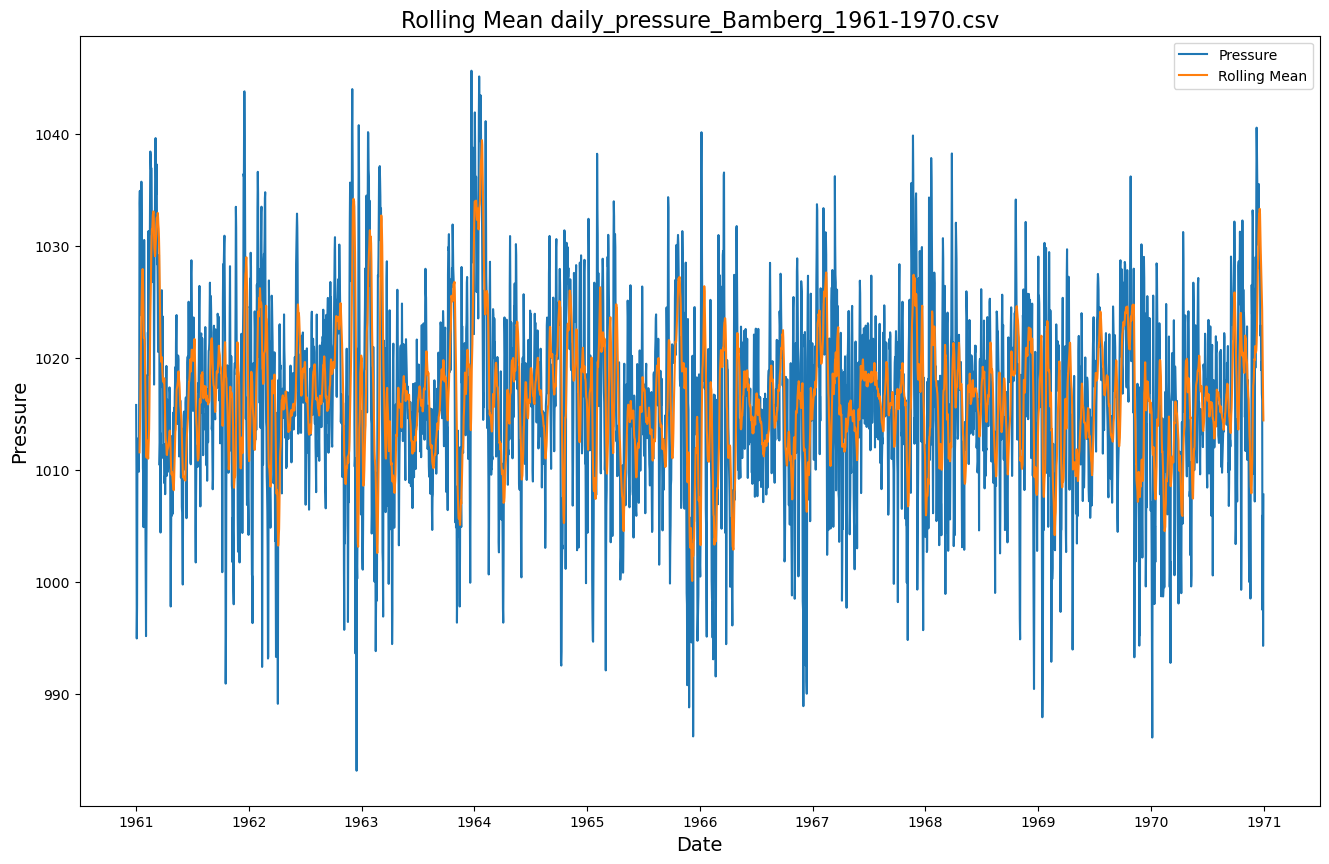

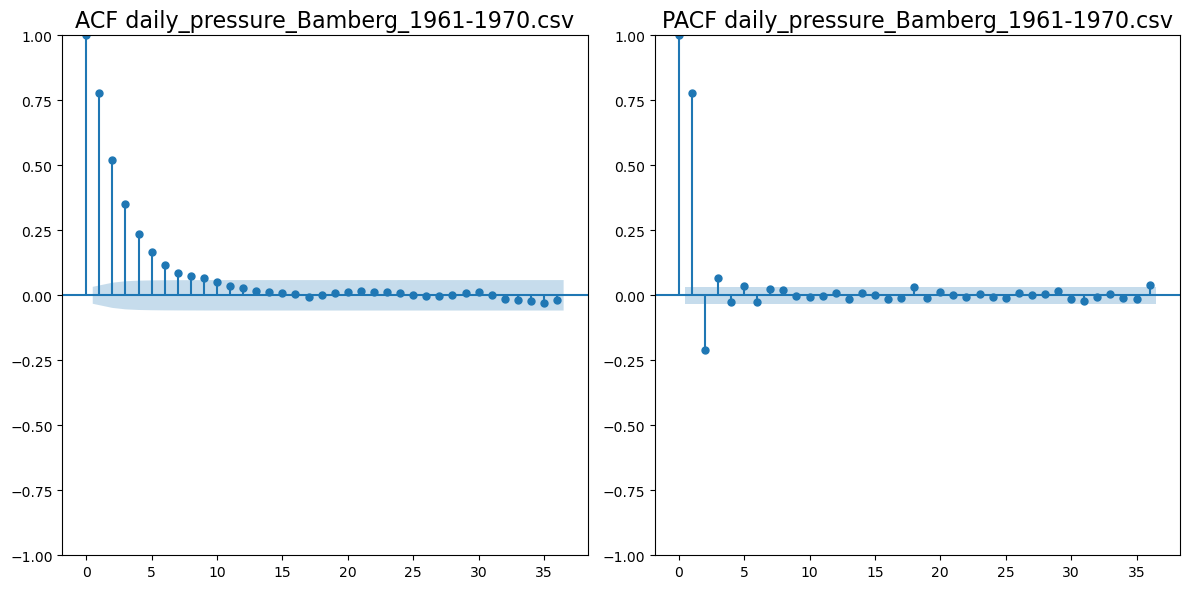

Information about: daily_pressure_Bamberg_1981-1990.csv
                 P
count  3650.000000
mean   1017.242375
std       9.057473
min     969.780000
25%    1011.820000
50%    1017.330000
75%    1022.905000
max    1045.280000


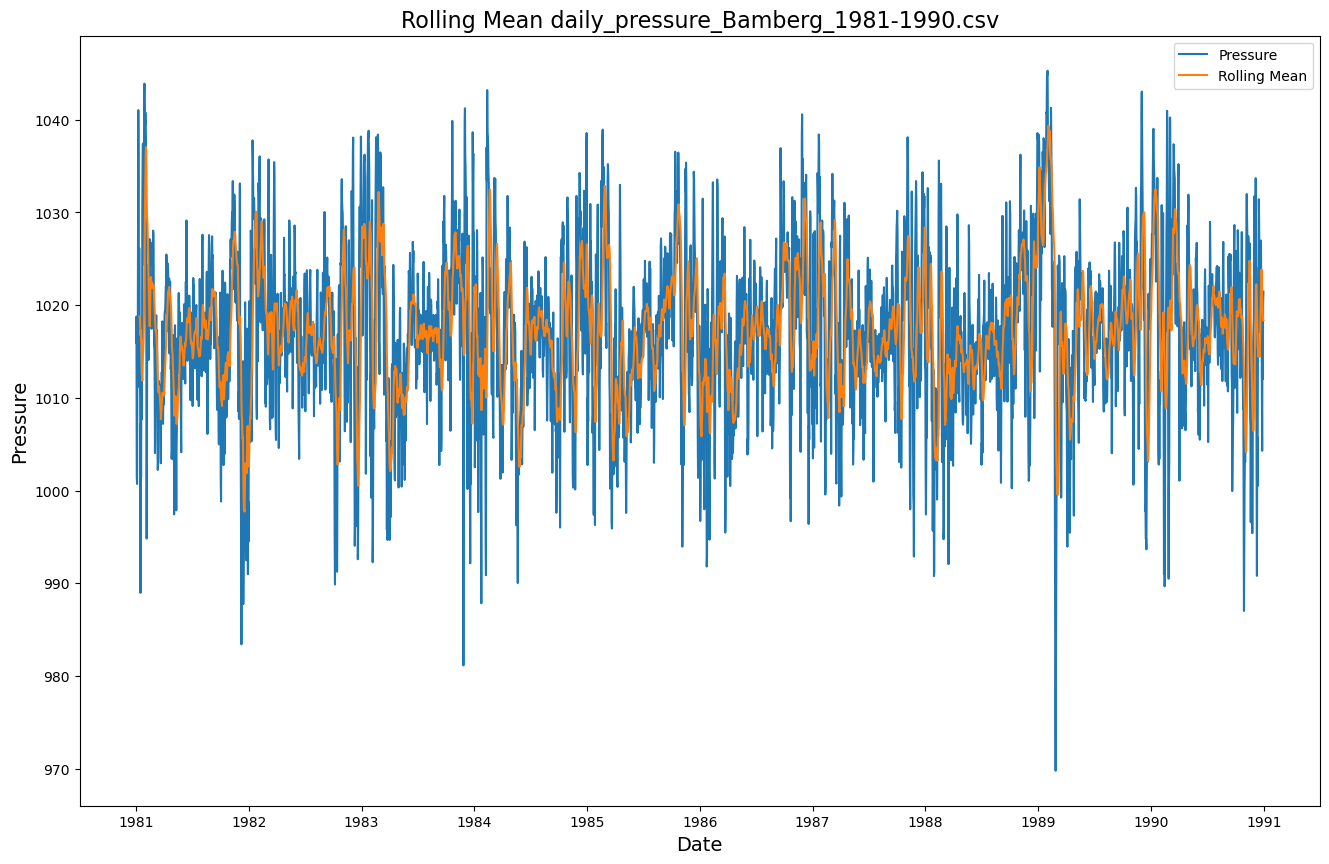

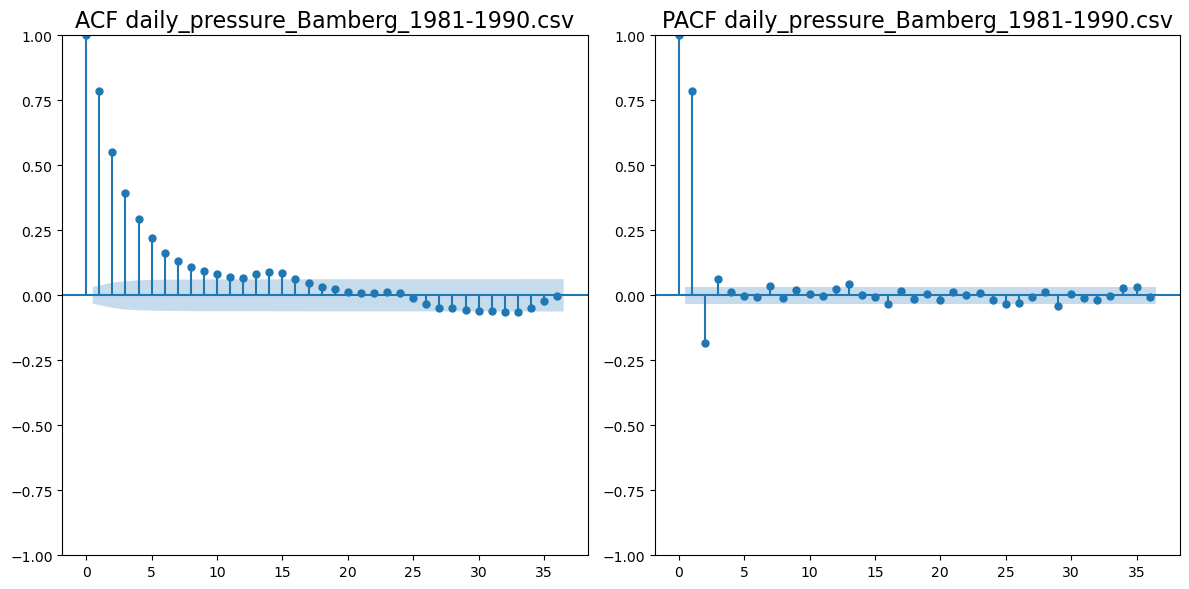

Information about: daily_pressure_Bamberg_2011-2020.csv
                 P
count  3653.000000
mean   1017.356300
std       8.355874
min     977.900000
25%    1012.350000
50%    1017.200000
75%    1022.590000
max    1046.800000


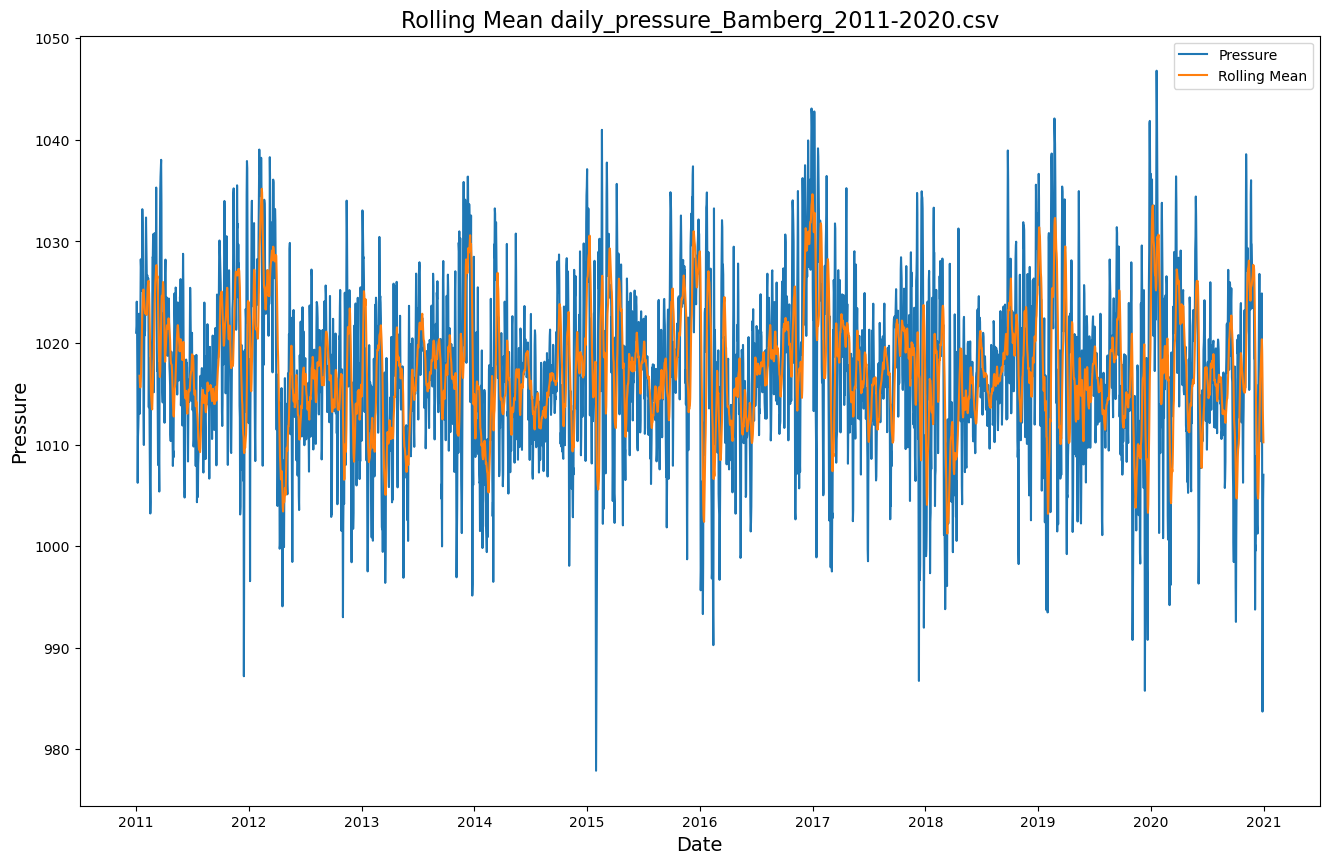

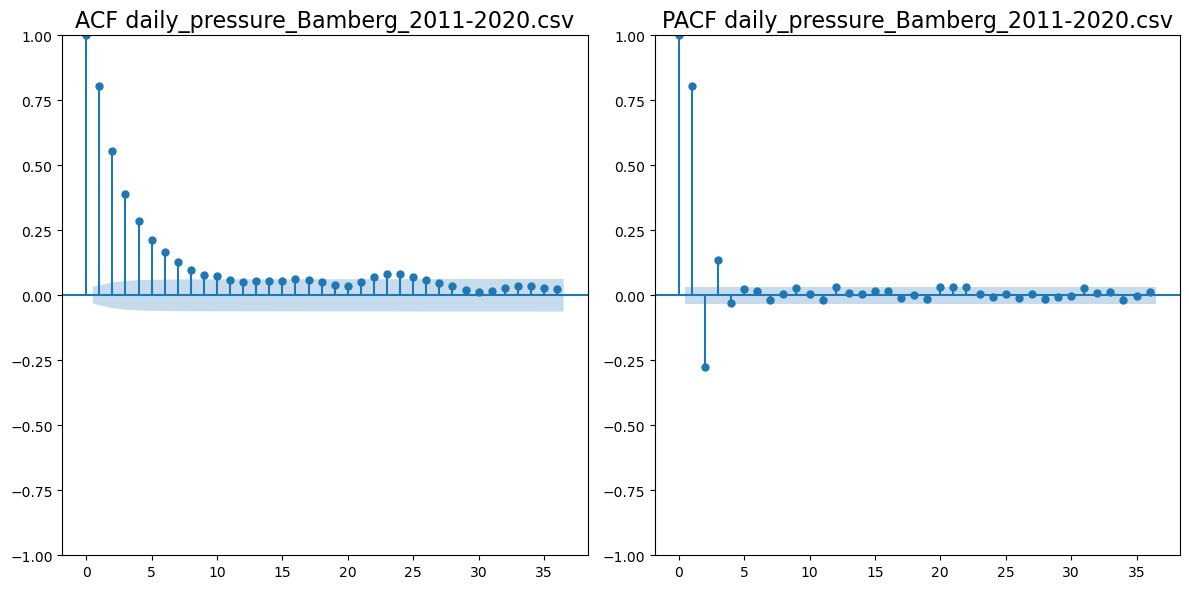

Information about: daily_pressure_Bamberg_1991-2000.csv
                 P
count  3653.000000
mean   1017.341174
std       8.632125
min     988.820000
25%    1011.850000
50%    1017.250000
75%    1022.830000
max    1043.600000


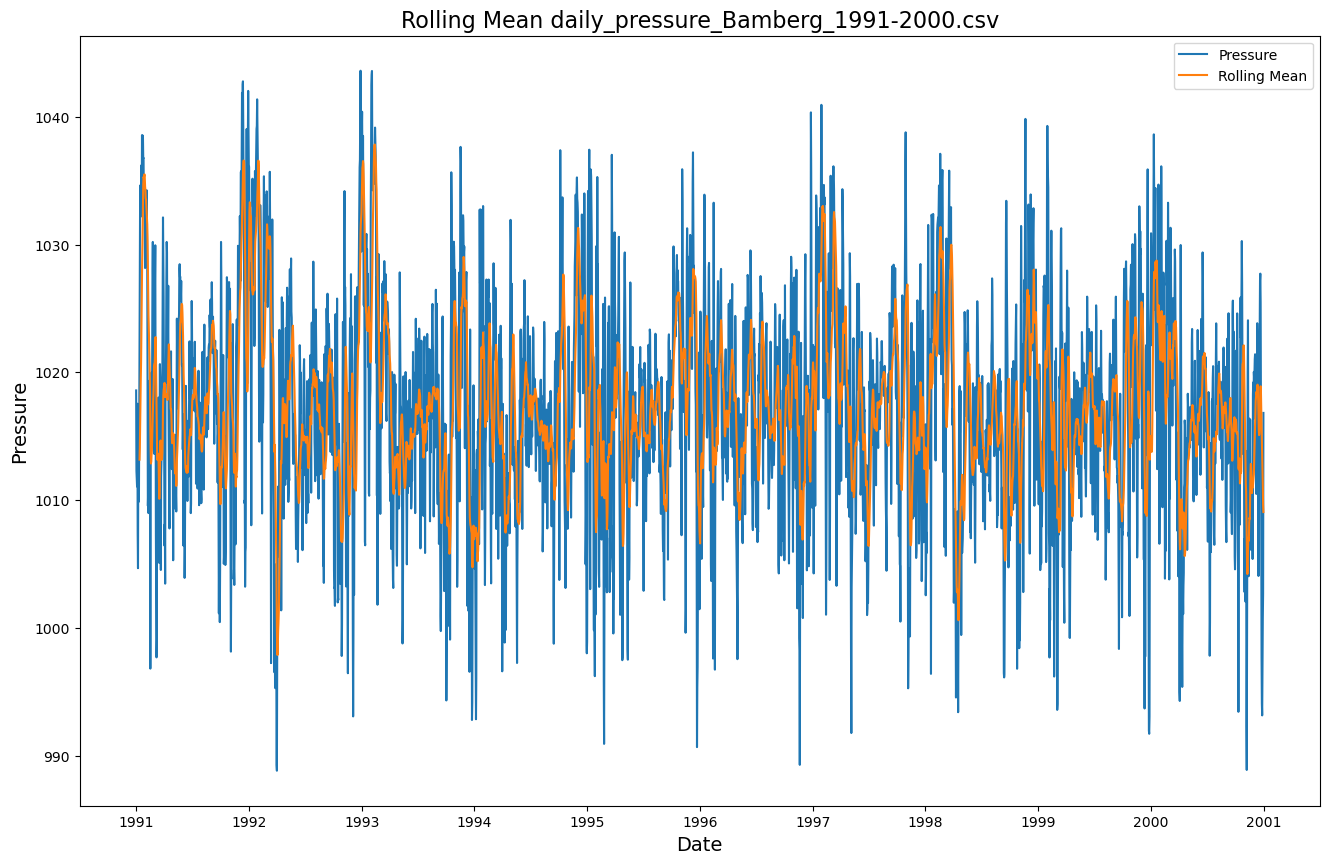

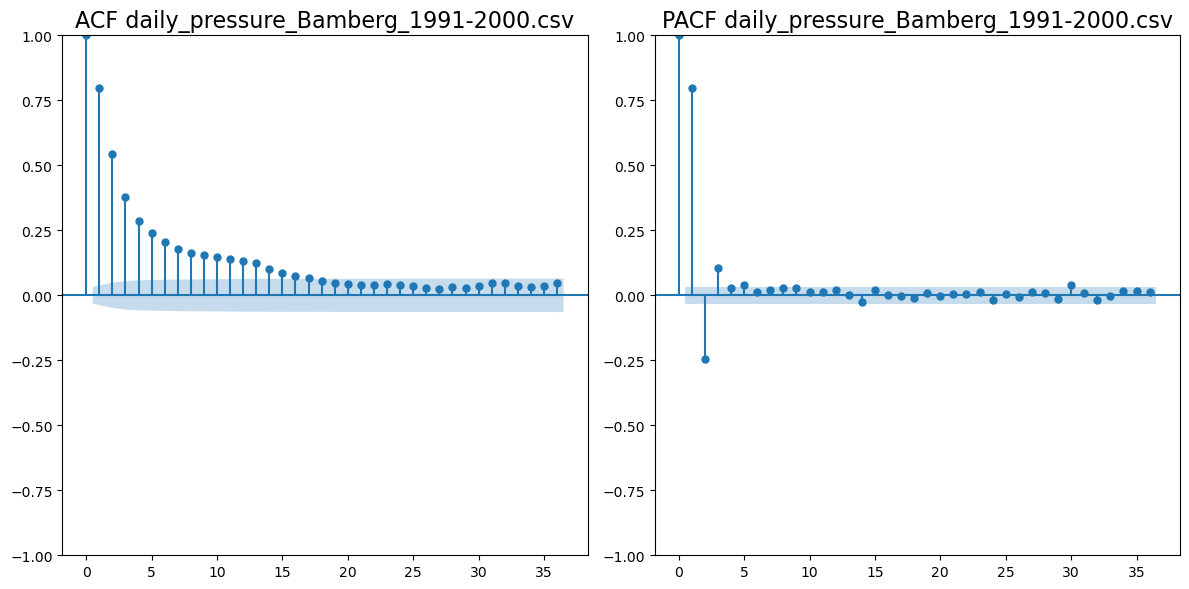

Information about: daily_pressure_Bamberg_1971-1980.csv
                 P
count  3647.000000
mean   1016.629871
std       8.645456
min     971.700000
25%    1011.250000
50%    1016.880000
75%    1022.110000
max    1040.300000


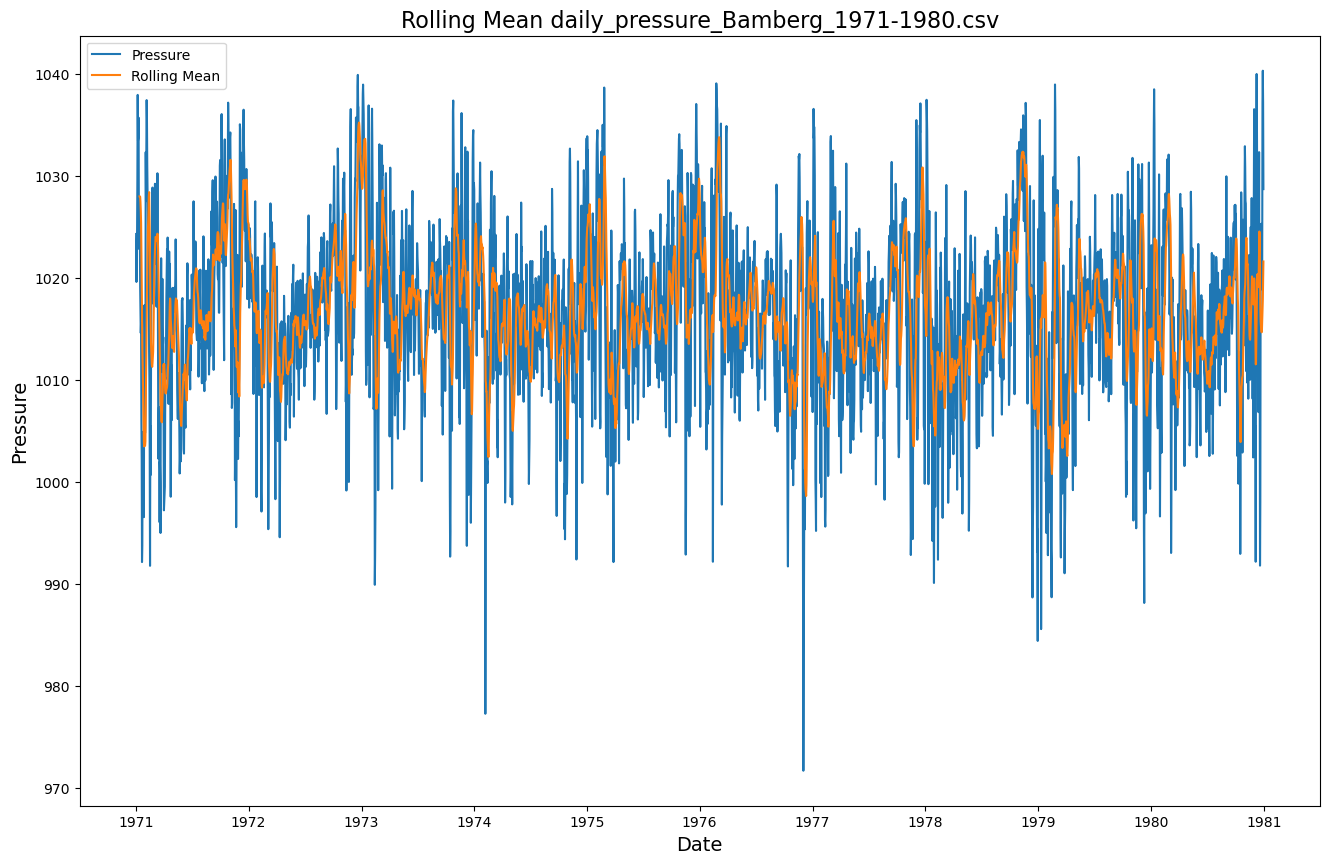

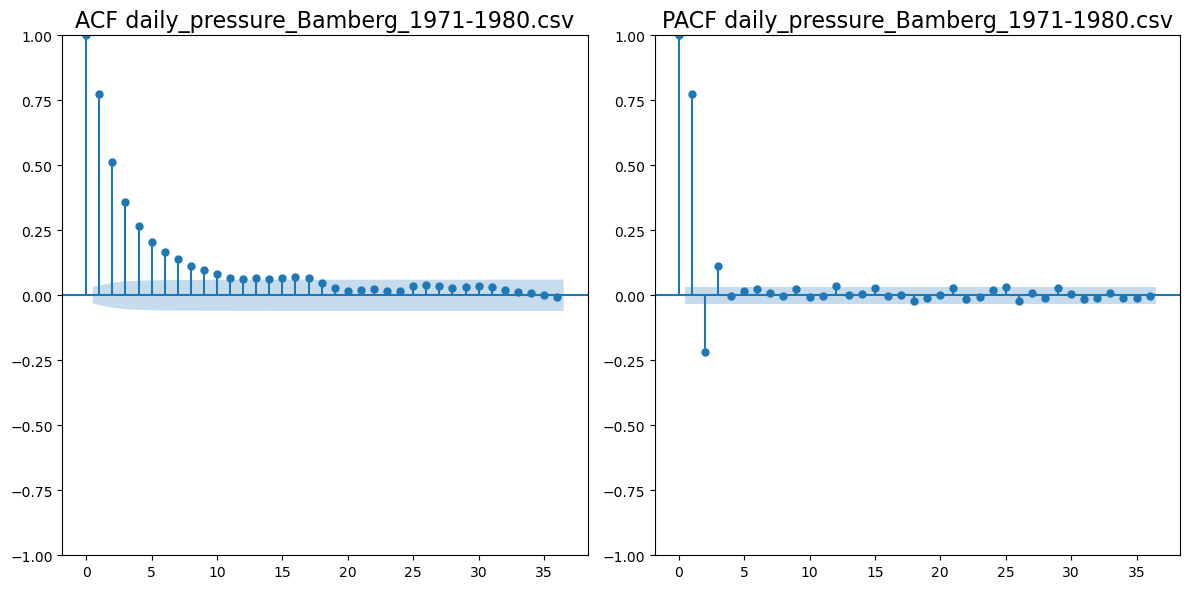

Information about: daily_pressure_Bamberg_2001-2010.csv
                 P
count  3652.000000
mean   1016.819154
std       8.514188
min     984.380000
25%    1011.780000
50%    1016.630000
75%    1022.250000
max    1045.540000


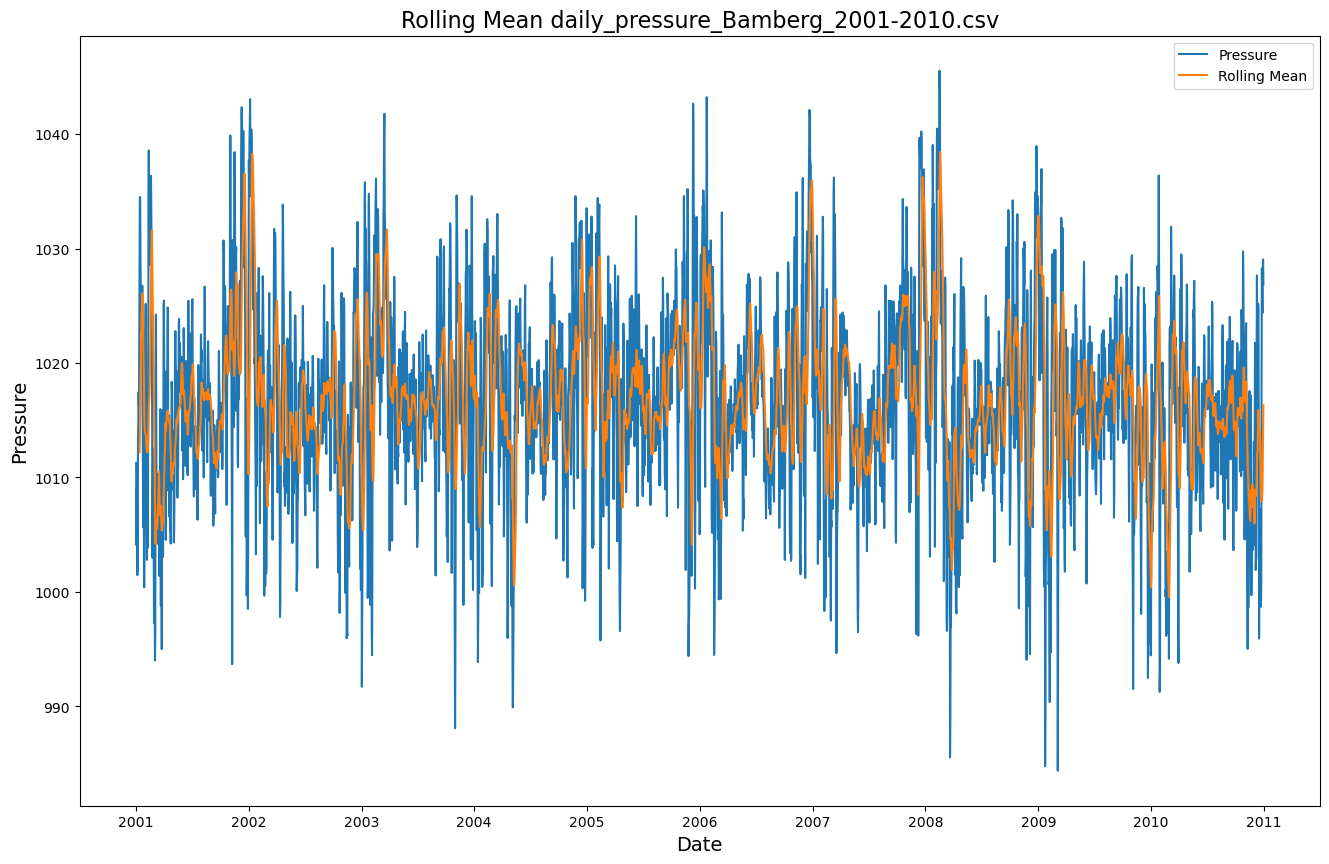

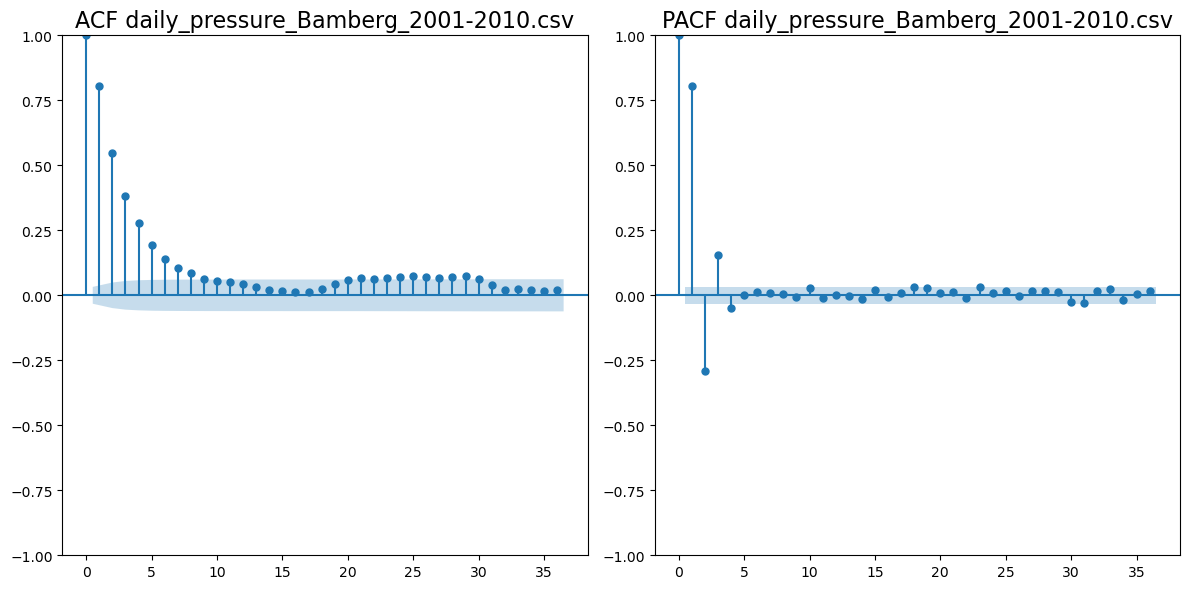

In [32]:
#become file lists
csv_files = glob.glob('Pressure/daily_pressure_Bamberg_*.csv')
file_names = [os.path.basename(file) for file in csv_files]
for file_name in file_names:
    df = pd.read_csv(f'Pressure/{file_name}', index_col=0, parse_dates=True)

    #impute missing values using nterpolate method if necessary
    missing_values = df['P'].isna() # or df.isnull()
    missing_count = missing_values.sum()
    if missing_count >=1:
        df['P'].interpolate(inplace=True)
        
    print(f'Information about: {file_name}')
    print(df.describe())
    # Extract the series values
    series = df.loc[:, 'P'].values
    plot_rolling_statistics(df,file_name)
    # Perform Tests
    #AD_Test = adf_test(series)
    #KPSS_test = kpss_test(series)
    # Print ADF test results
    #print_adf_results(AD_Test)
    #print_kpss_results(KPSS_test)
    # Plot ACF and PACF
    plot_acf_pacf(series,file_name)

information about: daily_pressure_Bamberg_1961-1970.csv
                 P
count  3614.000000
mean   1016.345581
std       8.544529
min     983.160000
25%    1011.080000
50%    1016.395000
75%    1021.600000
max    1045.610000


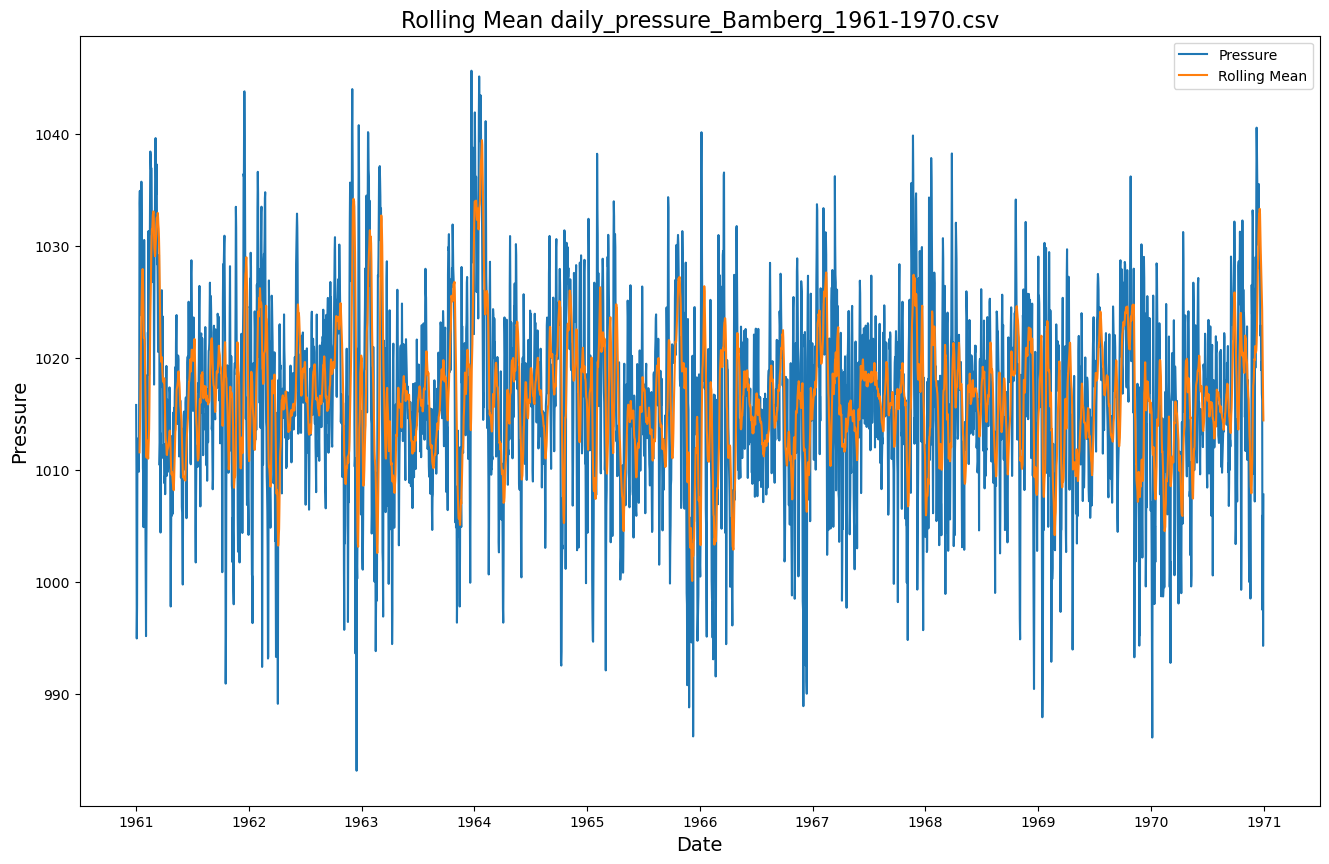

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_5615/209434721.py:103: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -16.2467565354011
p-value: 3.680201686397258e-29
n_lags: 7
Number of observations:3606
Critical Values:
   1%, -3.4321647424093515
Critical Values:
   5%, -2.8623418517008936
Critical Values:
   10%, -2.567196838319323
KPSS Statistic: 0.34547549319920157
p-value: 0.1
n_lags: 27
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


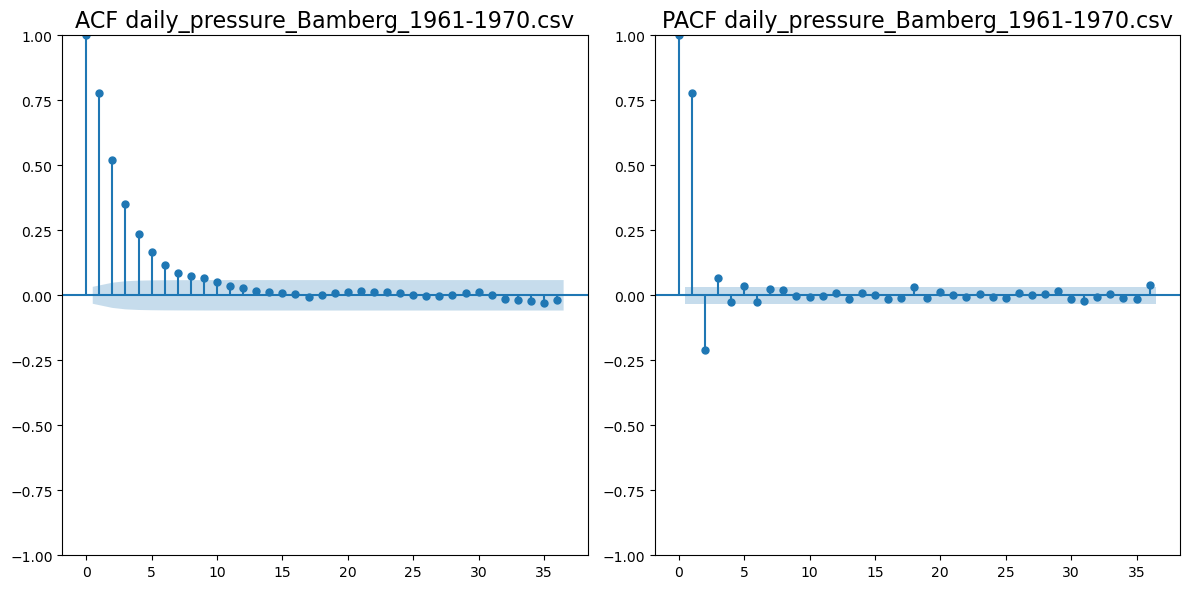

information about: daily_pressure_Bamberg_1981-1990.csv
                 P
count  3650.000000
mean   1017.242375
std       9.057473
min     969.780000
25%    1011.820000
50%    1017.330000
75%    1022.905000
max    1045.280000


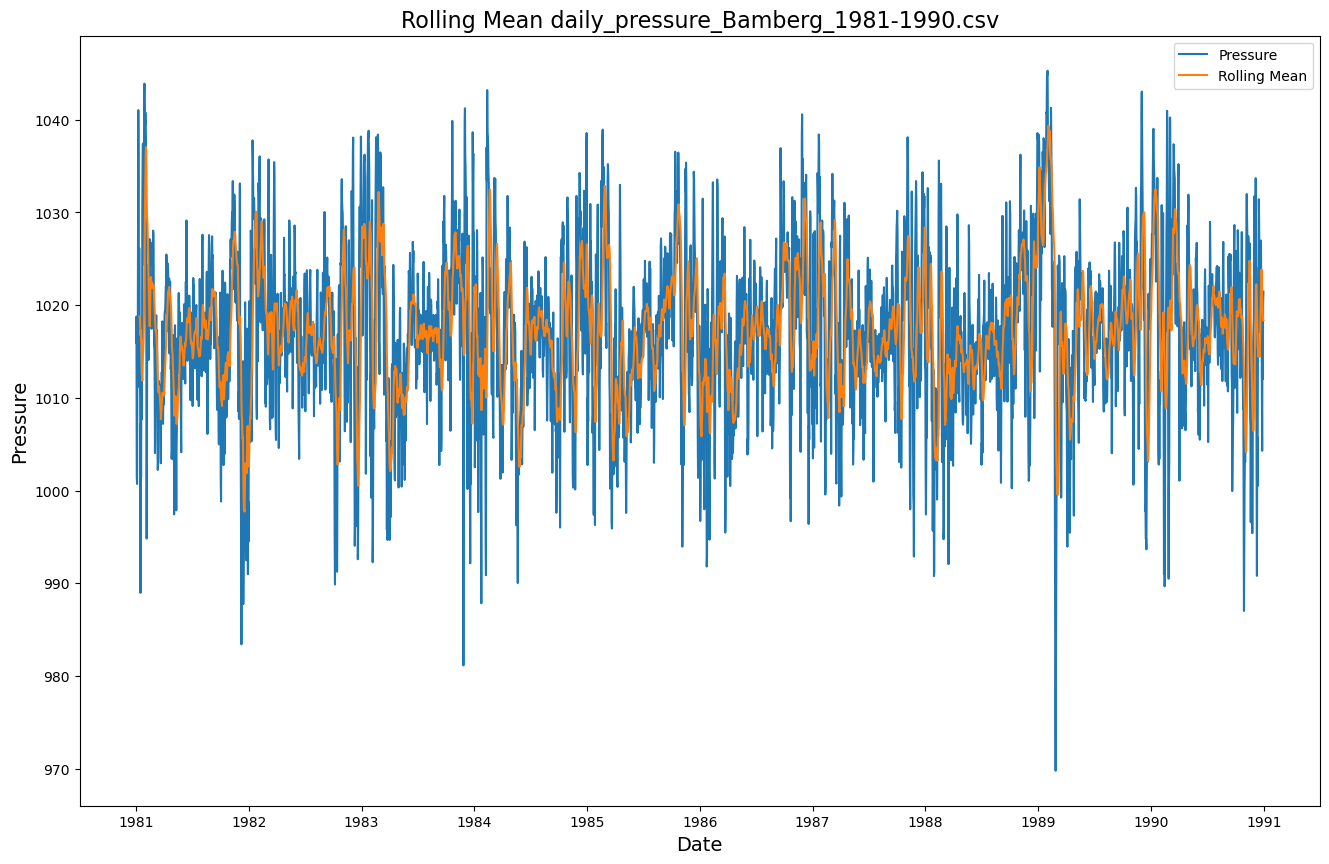

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_5615/209434721.py:103: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -20.686700822549813
p-value: 0.0
n_lags: 2
Number of observations:3647
Critical Values:
   1%, -3.4321443264763563
Critical Values:
   5%, -2.8623328335521245
Critical Values:
   10%, -2.5671920373518233
KPSS Statistic: 0.14961135426484895
p-value: 0.1
n_lags: 29
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


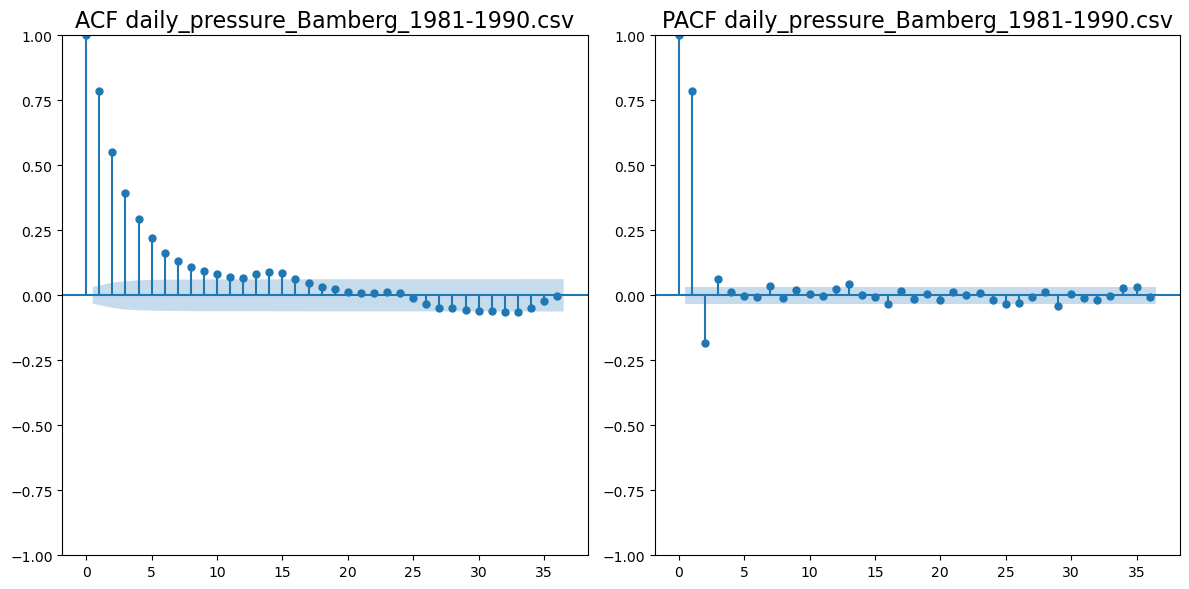

information about: daily_pressure_Bamberg_2011-2020.csv
                 P
count  3653.000000
mean   1017.356300
std       8.355874
min     977.900000
25%    1012.350000
50%    1017.200000
75%    1022.590000
max    1046.800000


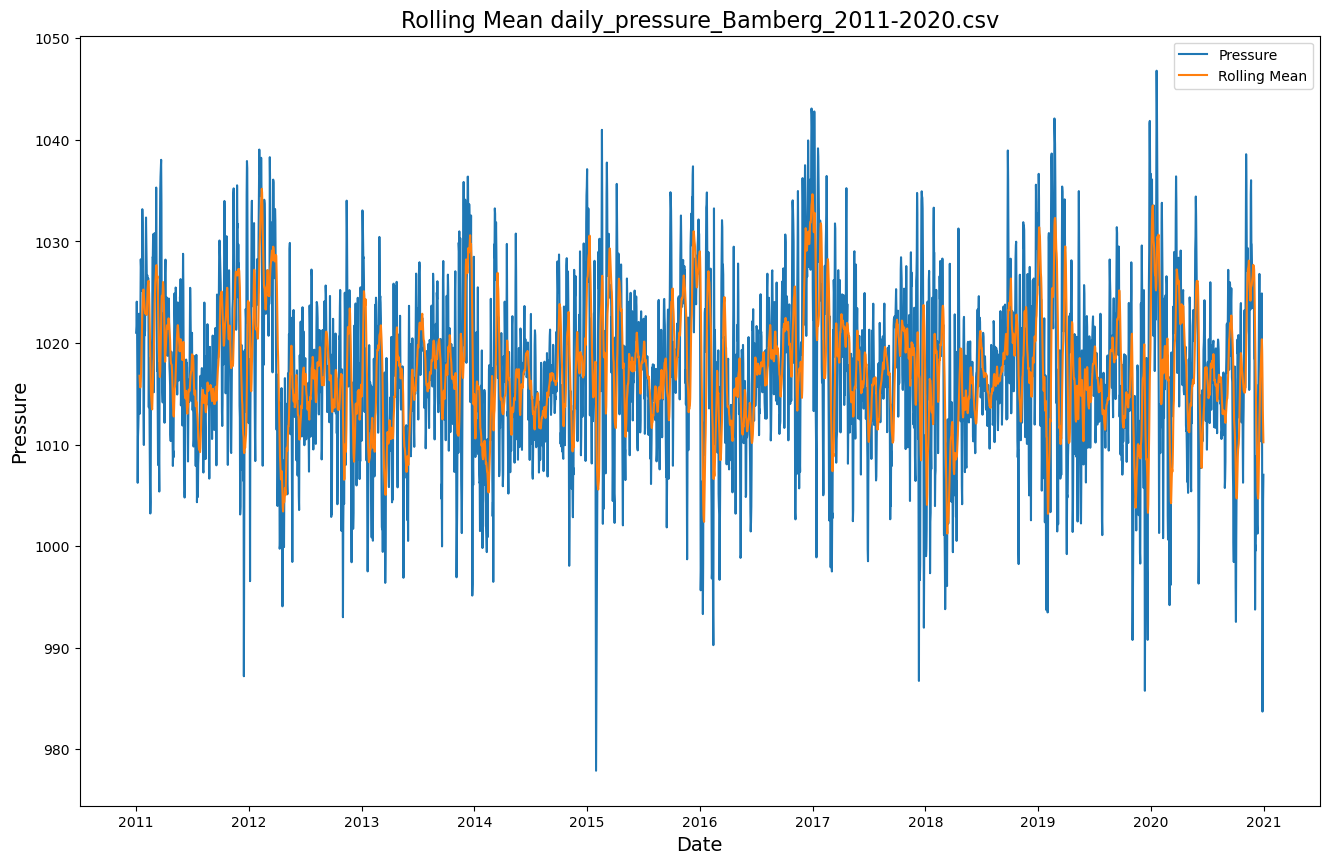

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_5615/209434721.py:103: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -19.599691425239623
p-value: 0.0
n_lags: 3
Number of observations:3649
Critical Values:
   1%, -3.4321433423211882
Critical Values:
   5%, -2.862332398828442
Critical Values:
   10%, -2.567191805919415
KPSS Statistic: 0.09885800428493105
p-value: 0.1
n_lags: 29
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


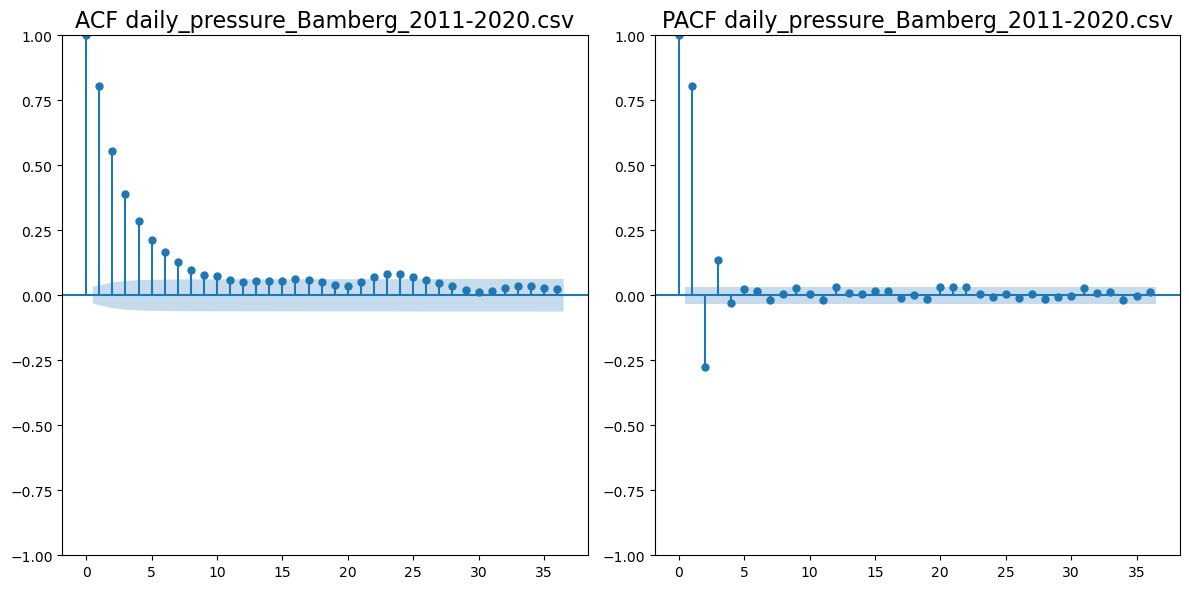

information about: daily_pressure_Bamberg_1991-2000.csv
                 P
count  3653.000000
mean   1017.341174
std       8.632125
min     988.820000
25%    1011.850000
50%    1017.250000
75%    1022.830000
max    1043.600000


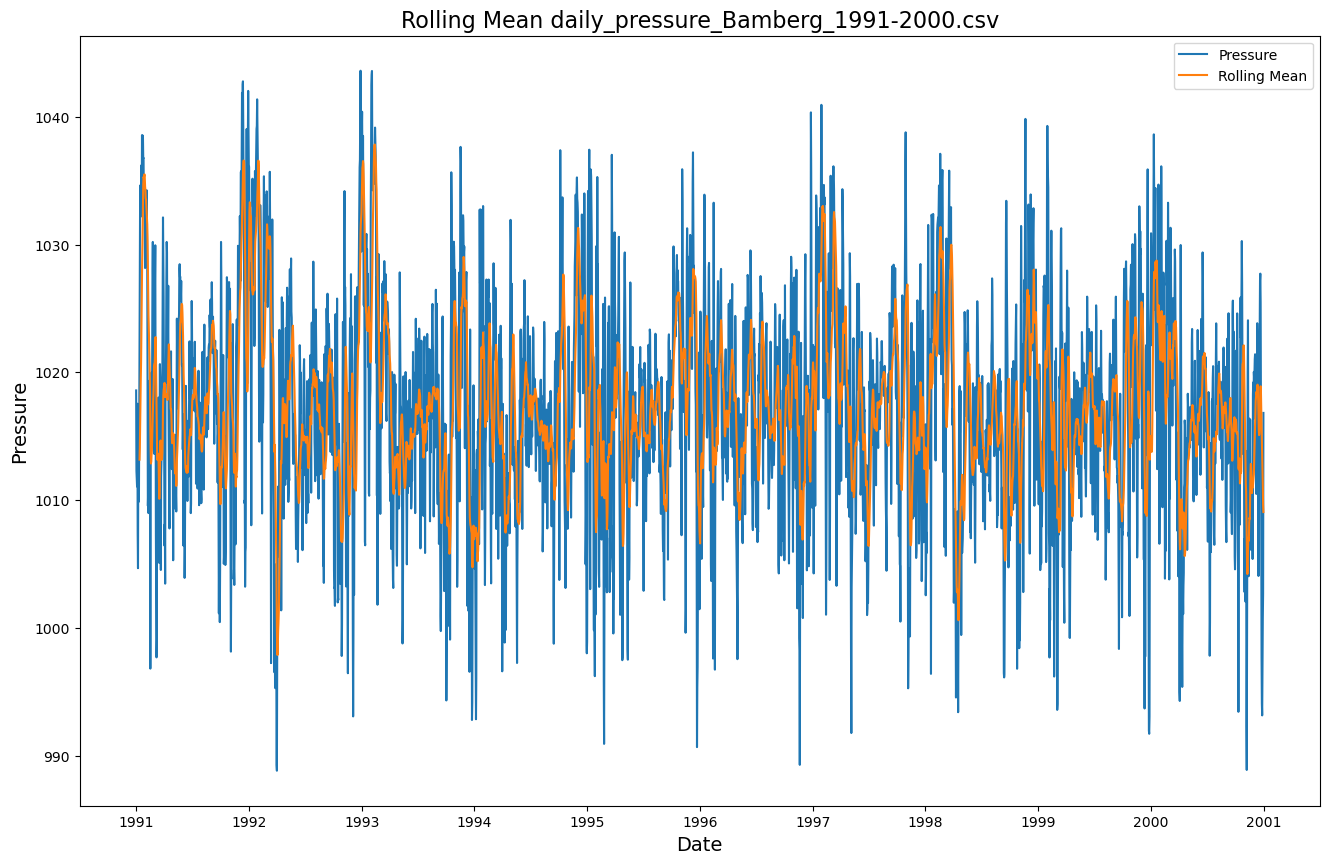

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_5615/209434721.py:103: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -17.465995018975107
p-value: 4.569958897841119e-30
n_lags: 4
Number of observations:3648
Critical Values:
   1%, -3.4321438342637873
Critical Values:
   5%, -2.8623326161306752
Critical Values:
   10%, -2.5671919216038828
KPSS Statistic: 0.3295396779879539
p-value: 0.1
n_lags: 30
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


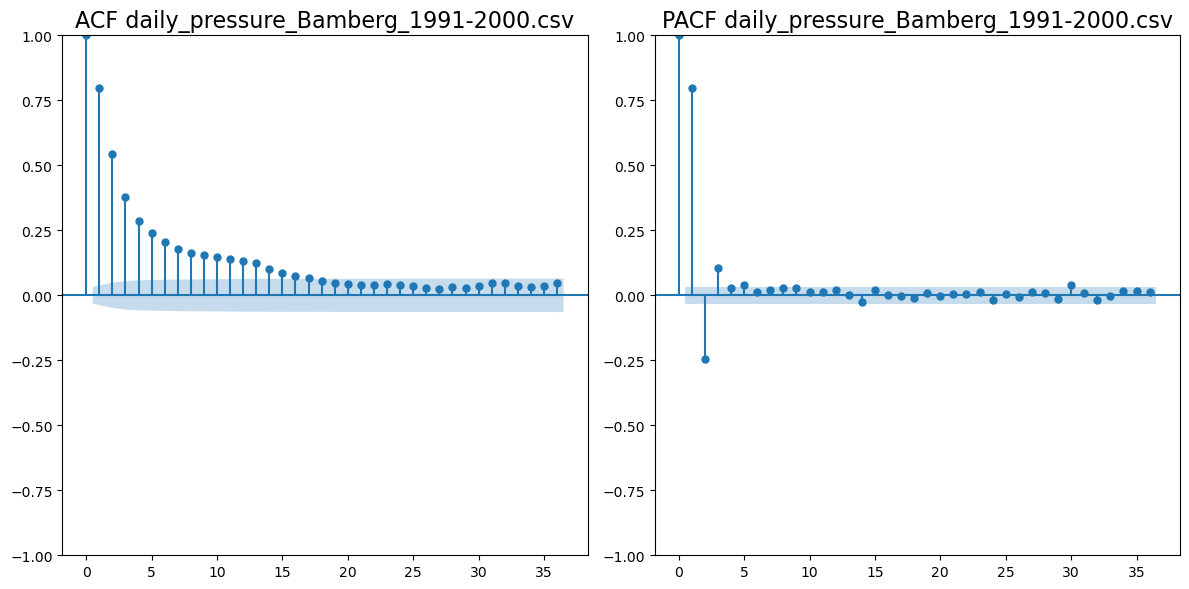

information about: daily_pressure_Bamberg_1971-1980.csv
                 P
count  3647.000000
mean   1016.629871
std       8.645456
min     971.700000
25%    1011.250000
50%    1016.880000
75%    1022.110000
max    1040.300000


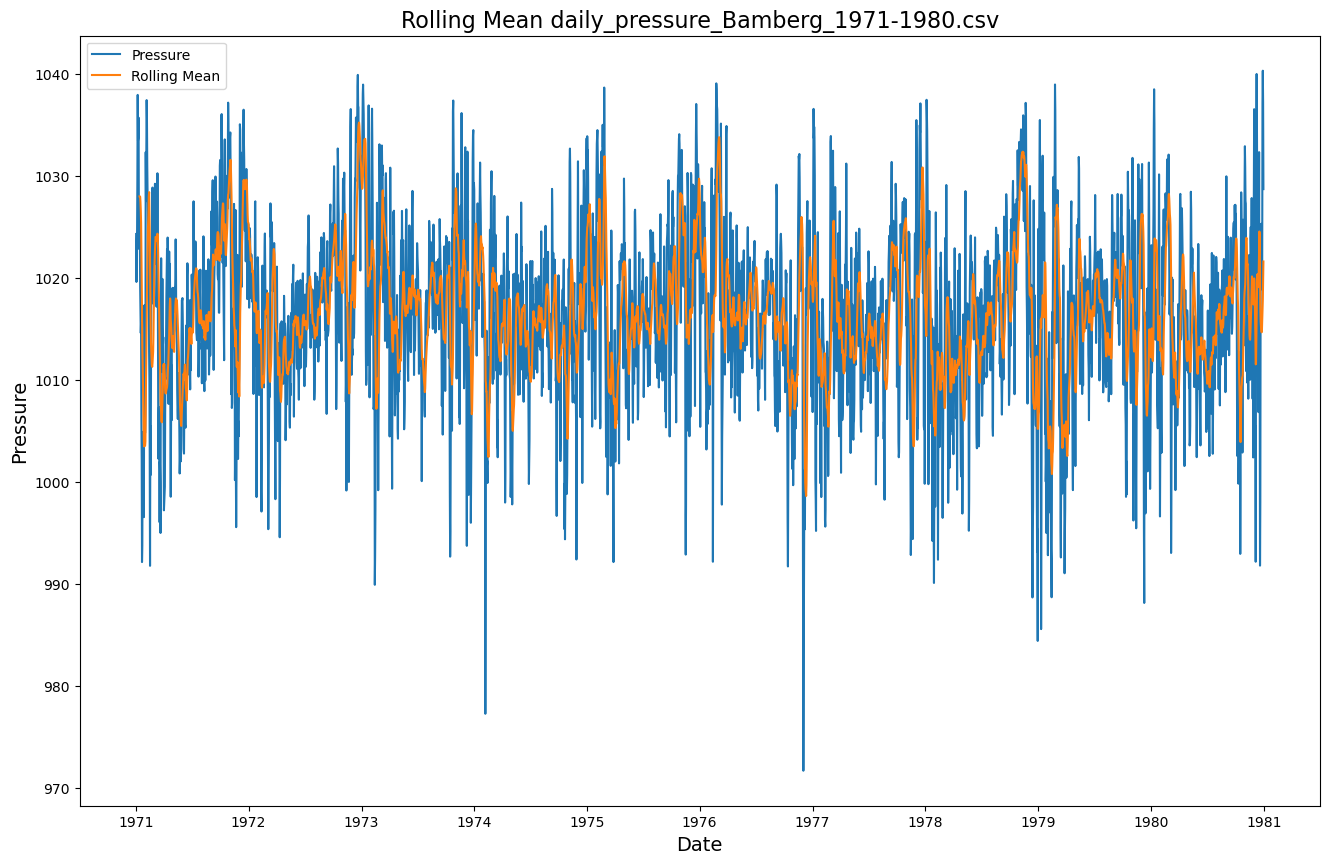

ADF Statistic: -20.72533343450095
p-value: 0.0
n_lags: 2
Number of observations:3644
Critical Values:
   1%, -3.4321458047361055
Critical Values:
   5%, -2.8623334865327488
Critical Values:
   10%, -2.567192384977004
KPSS Statistic: 0.3888187056614077
p-value: 0.08197469583560013
n_lags: 29
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


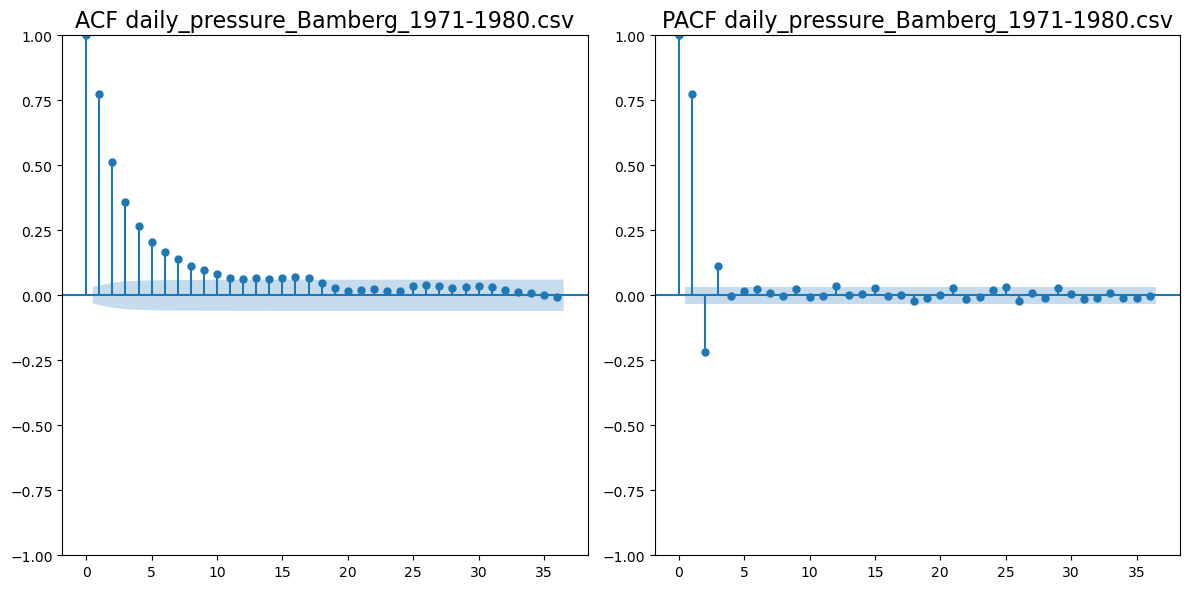

information about: daily_pressure_Bamberg_2001-2010.csv
                 P
count  3652.000000
mean   1016.819154
std       8.514188
min     984.380000
25%    1011.780000
50%    1016.630000
75%    1022.250000
max    1045.540000


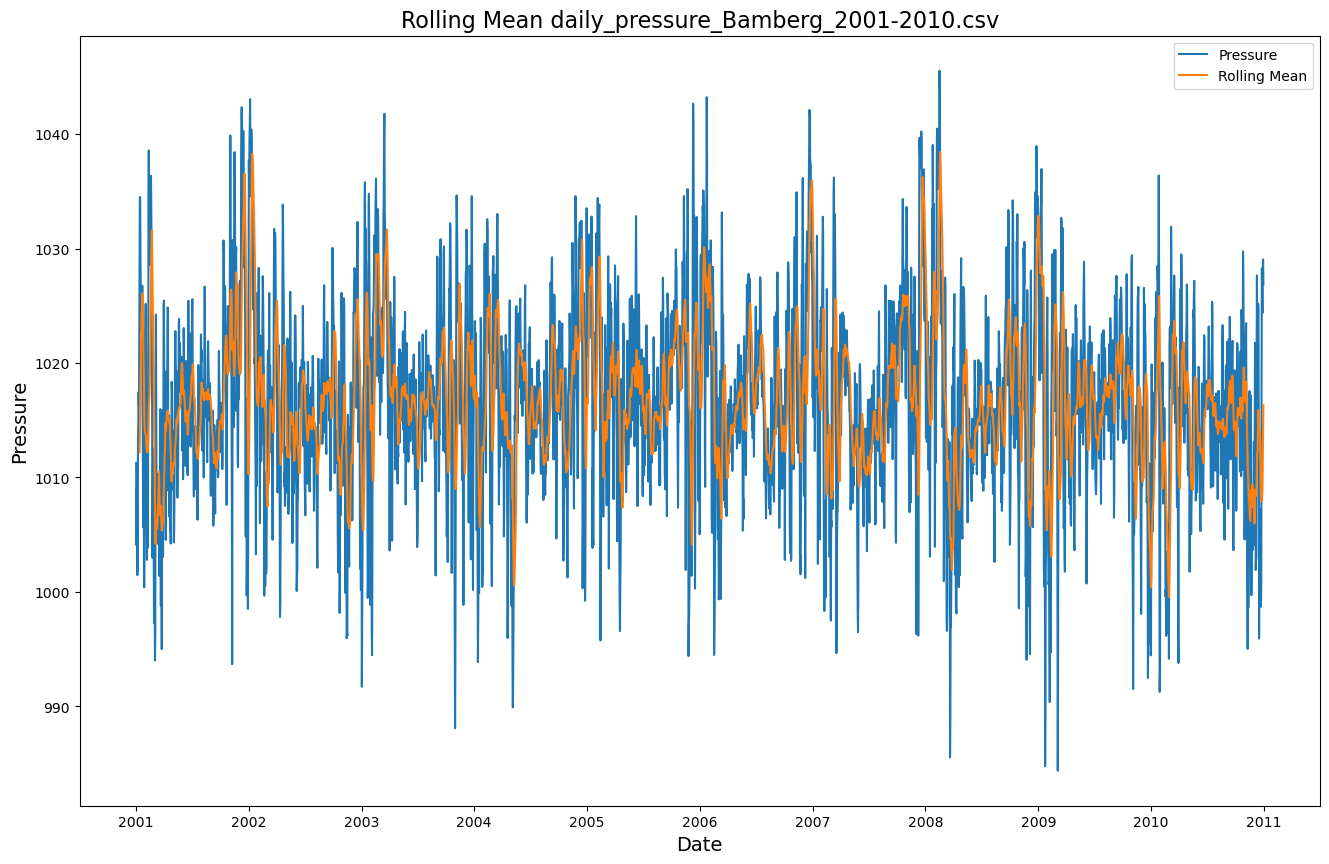

/var/folders/ks/j5w6xqqs1454hlwdqd8w2gg80000gn/T/ipykernel_5615/209434721.py:103: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_test = kpss(series, regression=reg)


ADF Statistic: -19.99518984836471
p-value: 0.0
n_lags: 3
Number of observations:3648
Critical Values:
   1%, -3.4321438342637873
Critical Values:
   5%, -2.8623326161306752
Critical Values:
   10%, -2.5671919216038828
KPSS Statistic: 0.2788007499244451
p-value: 0.1
n_lags: 28
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


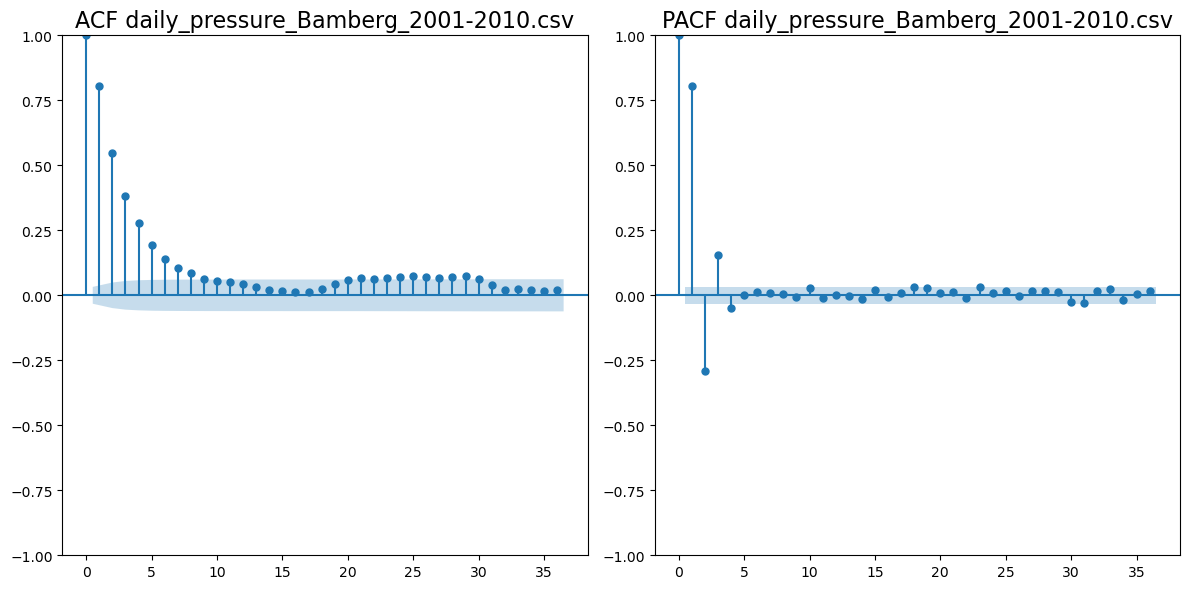

In [34]:
for file_name in file_names:
    df = pd.read_csv(f'Pressure/{file_name}', index_col=0, parse_dates=True)
    #check for missing values
    missing_values = df['P'].isna() # or df.isnull()
    #count missing values per column
    missing_count = missing_values.sum()
    if missing_count >=1:
        df['P'].interpolate(inplace=True)
        
    print(f'information about: {file_name}')
    print(df.describe())
    #extract the series values
    series = df.loc[:, 'P'].values
    plot_rolling_statistics(df,file_name)
    #perform Tests
    AD_Test = adf_test(series)
    KPSS_test = kpss_test(series)
    #print ADF test results
    print_adf_results(AD_Test)
    print_kpss_results(KPSS_test)
    #plot ACF and PACF
    plot_acf_pacf(series,file_name)
    #print(missing_count)
